In [1]:
import os   # for path operations
import datetime

import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17632625410143636353
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11159468647338742931
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# nb_input_series : time + 9 IMU data + optional prev. beta (min 10)
# nb_outputs : beta () or quvaternion representation) (min 1)

def make_1d_convnet(window_size, filter_length, nb_input_series=10, nb_outputs=1,nb_filter=4):
  model = Sequential()
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(nb_outputs,activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

In [4]:
def make_timeseries_instances(timeseries,window_size):
  timeseries = np.asarray(timeseries)
  assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
  X = np.atleast_3d(np.array([timeseries[start:start+window_size] for start in range(0,timeseries.shape[0]-window_size)]))
  y = timeseries[window_size:]
  return X,y

In [71]:
def evalute_timeseries(X, Y, window_size, filter_length, nb_filter, valid_split, test_split):
  nb_samples = X.shape[0]
  nb_series = X.shape[3]
  
  # Model definition (previously definied) 10 input chanel, 1 output chanel
  model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series,
                        nb_outputs=nb_series,nb_filter=nb_filter)
  model.summary()
    
  valid_size = int(nb_samples*(1-test_split-valid_split))
  test_size = int(nb_samples*(1-test_split))
  X_train, Y_train = X[:valid_size], Y[:valid_size]
  X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
  X_test, Y_test   = X[test_size:], Y[test_size:]
    
  model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2)
    
  preds=model.predict(X_test)
  targets = Y_test

  plt.plot(preds)
  plt.plot(targets)

# Load Data

In [6]:
lock_meas = '..\\DATA\\RAW\\Measure_02'
file_list = os.listdir(lock_meas)
nb_meas = len(file_list)/4
print("Number of Measurements: %0.f" % nb_meas)

Number of Measurements: 6


In [7]:
meas_list = []
for FILE_NAME in file_list:
    meas_list.append(FILE_NAME[0:22])
meas_list = list(set(meas_list))

In [18]:
# Load in one favourite measurement block
meas_id = 5
print(str(meas_list[meas_id]))

if meas_id>(nb_meas-1):
    print('Error: Out of range. Meas_id set to default 0')
    meas = 0
meas_date = str(meas_list[meas_id])

imu_data = pd.read_csv(lock_meas + '\\' + meas_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

mocap_data = pd.read_csv(lock_meas + '\\' + meas_date + 'MoCap.txt',
                                 sep='\t',
                                 decimal=',',
                                 names=['time', 'x', 'y', 'z', 'tracked', 'beta', 'Qx', 'Qy', 'Qz', 'Qw'])


2018_ 10_ 19_18_23_39_


In [9]:
imu_data.head(5)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2
0,182339.3406,0.000,-0.052,1.025,-0.846,-0.101,-0.148,0.000,0.000,0.000
1,182339.3506,-0.000,-0.053,1.025,-0.987,0.302,-0.134,0.000,0.000,0.000
2,182339.3605,0.000,-0.053,1.025,-0.886,0.262,-0.107,-0.345,-0.282,0.058
3,182339.3695,0.001,-0.053,1.025,-0.806,0.101,0.107,-0.345,-0.282,0.064
4,182339.3785,0.000,-0.052,1.026,-0.987,0.161,-0.148,-0.345,-0.282,0.058


In [10]:
mocap_data.head(5)

,time,x,y,z,tracked,beta,Qx,Qy,Qz,Qw
0,182339.3406,0.711,0.212,-0.718,1.0,6.381,0.012,-0.056,0.005,0.998
1,182339.3506,0.711,0.212,-0.718,1.0,6.392,0.012,-0.056,0.005,0.998
2,182339.3605,0.711,0.212,-0.718,1.0,6.397,0.013,-0.056,0.005,0.998
3,182339.3695,0.711,0.212,-0.718,1.0,6.388,0.012,-0.056,0.005,0.998
4,182339.3785,0.711,0.212,-0.718,1.0,6.404,0.012,-0.056,0.005,0.998


In [11]:
data = pd.merge(imu_data, mocap_data, on=['time'], how='inner')
len(data)

8671

In [12]:
data.head()

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,x,y,z,tracked,beta,Qx,Qy,Qz,Qw
0,182339.3406,0.000,-0.052,1.025,-0.846,-0.101,-0.148,0.000,0.000,0.000,0.711,0.212,-0.718,1.0,6.381,0.012,-0.056,0.005,0.998
1,182339.3506,-0.000,-0.053,1.025,-0.987,0.302,-0.134,0.000,0.000,0.000,0.711,0.212,-0.718,1.0,6.392,0.012,-0.056,0.005,0.998
2,182339.3605,0.000,-0.053,1.025,-0.886,0.262,-0.107,-0.345,-0.282,0.058,0.711,0.212,-0.718,1.0,6.397,0.013,-0.056,0.005,0.998
3,182339.3695,0.001,-0.053,1.025,-0.806,0.101,0.107,-0.345,-0.282,0.064,0.711,0.212,-0.718,1.0,6.388,0.012,-0.056,0.005,0.998
4,182339.3785,0.000,-0.052,1.026,-0.987,0.161,-0.148,-0.345,-0.282,0.058,0.711,0.212,-0.718,1.0,6.404,0.012,-0.056,0.005,0.998


In [14]:
data.shape

(8671, 19)

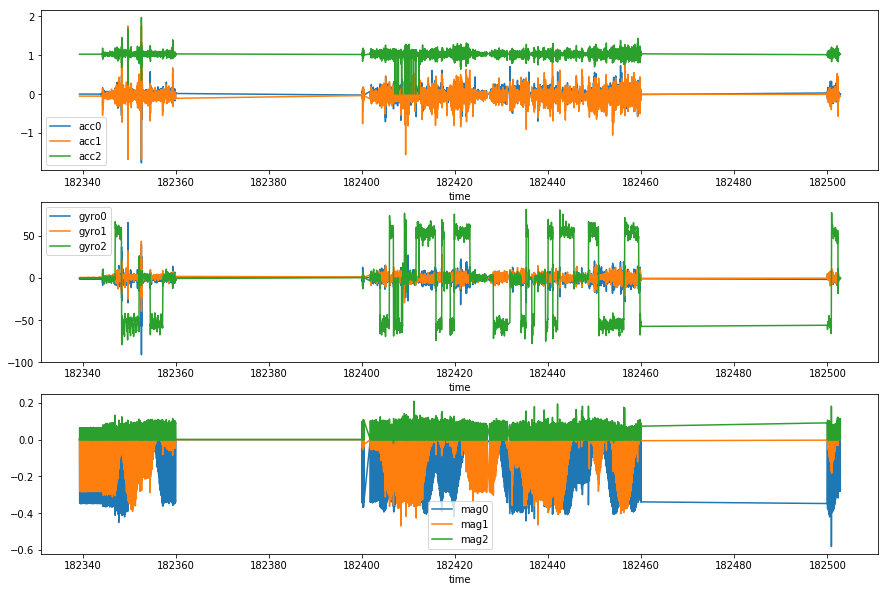

In [17]:
f1, (ax1, ax2, ax3) = plt.subplots(3, 1)
data.plot(x='time', y='acc0', figsize=(15,10), ax=ax1)
data.plot(x='time', y='acc1', ax=ax1)
data.plot(x='time', y='acc2', ax=ax1)
data.plot(x='time', y='gyro0', ax=ax2)
data.plot(x='time', y='gyro1', ax=ax2)
data.plot(x='time', y='gyro2', ax=ax2)
data.plot(x='time', y='mag0', ax=ax3)
data.plot(x='time', y='mag1', ax=ax3)
data.plot(x='time', y='mag2', ax=ax3)

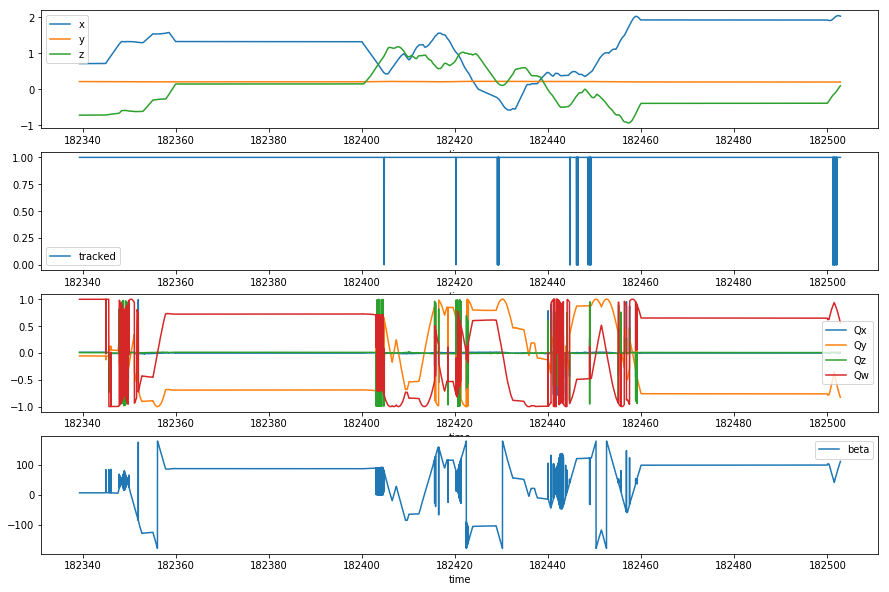

In [22]:
f2, (ax4, ax5, ax6, ax7) = plt.subplots(4, 1)
data.plot(x='time', y='x', figsize=(15,10), ax=ax4)
data.plot(x='time', y='y', ax=ax4)
data.plot(x='time', y='z', ax=ax4)
data.plot(x='time', y='tracked', ax=ax5)
data.plot(x='time', y='Qx', ax=ax6)
data.plot(x='time', y='Qy', ax=ax6)
data.plot(x='time', y='Qz', ax=ax6)
data.plot(x='time', y='Qw', ax=ax6)
data.plot(x='time', y='beta', ax=ax7)

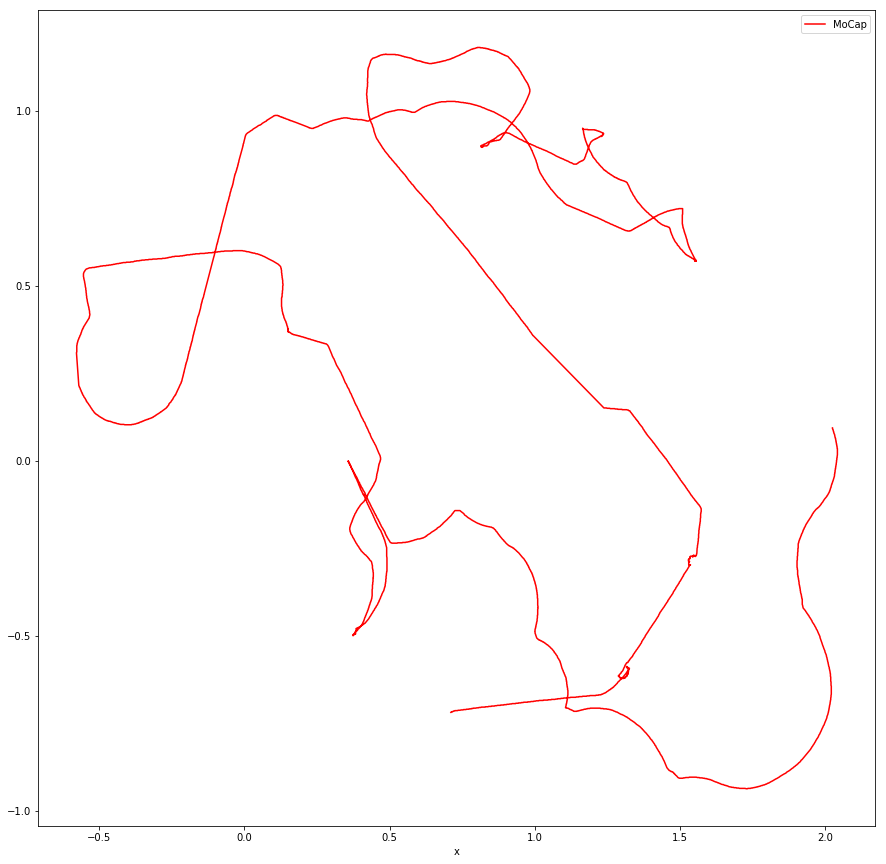

In [20]:
data.plot(x='x', y='z', color='red', figsize=(15,15), label='MoCap')

In [85]:
Y = data['beta'][window_size:]
X= data[list(data.columns[0:9])]

In [86]:
X.head(5)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1
0,182339.3406,0.000,-0.052,1.025,-0.846,-0.101,-0.148,0.000,0.000
1,182339.3506,-0.000,-0.053,1.025,-0.987,0.302,-0.134,0.000,0.000
2,182339.3605,0.000,-0.053,1.025,-0.886,0.262,-0.107,-0.345,-0.282
3,182339.3695,0.001,-0.053,1.025,-0.806,0.101,0.107,-0.345,-0.282
4,182339.3785,0.000,-0.052,1.026,-0.987,0.161,-0.148,-0.345,-0.282


In [87]:
Y.head(5)

20    6.386
21    6.398
22    6.393
23    6.386
24    6.400
Name: beta, dtype: float64

In [88]:
print(X.shape)
print(Y.shape)

(8671, 9)
(8651,)


In [89]:
X.shape[0]

8671

In [82]:
#X = np.atleast_3d(np.array([X[start:start+window_size] for start in range(0,X.shape[0]-window_size)]))
for start in range(0,X.shape[0]-window_size):
    X = X[start:start+window_size] 

In [75]:
X.shape

(0, 20, 20, 19)

In [65]:
X.shape[0]

8631

In [67]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 50
batch_size = 16
vs = 0.15
ts = 0.15

In [72]:
evalute_timeseries(X, Y, window_size,filter_length,nb_filter, vs, ts)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                171       
Total params: 639
Trainable params: 639
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected conv1d_1_input to have 3 dimensions, but got array with shape (6041, 20, 20, 19)